In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [15]:
# Fetch stock data
def fetch_stock_data(ticker):
    df = yf.download(ticker, period='1y')
    return df[['Close']]

In [16]:
# Preprocess data
def preprocess_data(data, time_step=60):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(time_step, len(data_scaled)):
        X.append(data_scaled[i - time_step:i])
        y.append(data_scaled[i])

    X, y = np.array(X), np.array(y)
    return X, y, scaler


In [17]:
# Split data
def split_data(X, y, split_ratio=0.8):
    split = int(len(X) * split_ratio)
    return X[:split], X[split:], y[:split], y[split:]

In [18]:
# Generalized model builder
def build_model(model_type, input_shape, units=50, dropout_rate=0.2, dense_units=50):
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(units, return_sequences=False, input_shape=input_shape))

    elif model_type == "LSTM":
        model.add(LSTM(units, return_sequences=False, input_shape=input_shape))

    elif model_type == "GRU":
        model.add(GRU(units, return_sequences=False, input_shape=input_shape))

    elif model_type == "1D-CNN":
        model.add(Conv1D(filters=units, kernel_size=3, activation='relu', input_shape=input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())

    if model_type in ["RNN", "LSTM", "GRU"]:
        model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer

    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


In [19]:
# Predict future 7 days
def predict_future(model, last_sequence, scaler, days=7):
    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(days):
        pred = model.predict(current_seq.reshape(1, *current_seq.shape))[0, 0]
        predictions.append(pred)
        current_seq = np.append(current_seq[1:], [[pred]], axis=0)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

In [20]:
# Run model pipeline
def run_model_pipeline(model_name, df):
    X, y, scaler = preprocess_data(df)
    X_train, X_test, y_train, y_test = split_data(X, y)

    model = build_model(model_name, (X.shape[1], X.shape[2]))
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred).flatten()

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    last_sequence = X[-1]
    future = predict_future(model, last_sequence, scaler)

    return {"MSE": mse, "MAE": mae, "Future 7 Days": future, "actual": y_test_inv, "predictions": y_pred_inv}

In [21]:
# Plot predictions
def plot_predictions(model_name, y_test_inv, y_pred_inv):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label='Actual', color='blue')
    plt.plot(y_pred_inv, label='Predicted', color='red', linestyle='--')
    plt.title(f"{model_name} - Actual vs Predicted Stock Price")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [22]:
# Plot loss comparison
def plot_loss_comparison(results):
    model_names = list(results.keys())
    mse_values = [results[model]["MSE"] for model in model_names]
    mae_values = [results[model]["MAE"] for model in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, mse_values, width, label='MSE', color='b')
    ax.bar(x + width/2, mae_values, width, label='MAE', color='g')

    ax.set_xlabel('Model')
    ax.set_ylabel('Loss (MSE / MAE)')
    ax.set_title('Model Loss Comparison (MSE vs MAE)')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    plt.tight_layout()
    plt.show()

Enter the stock ticker (e.g., AAPL, MSFT, TSLA): AAPL


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


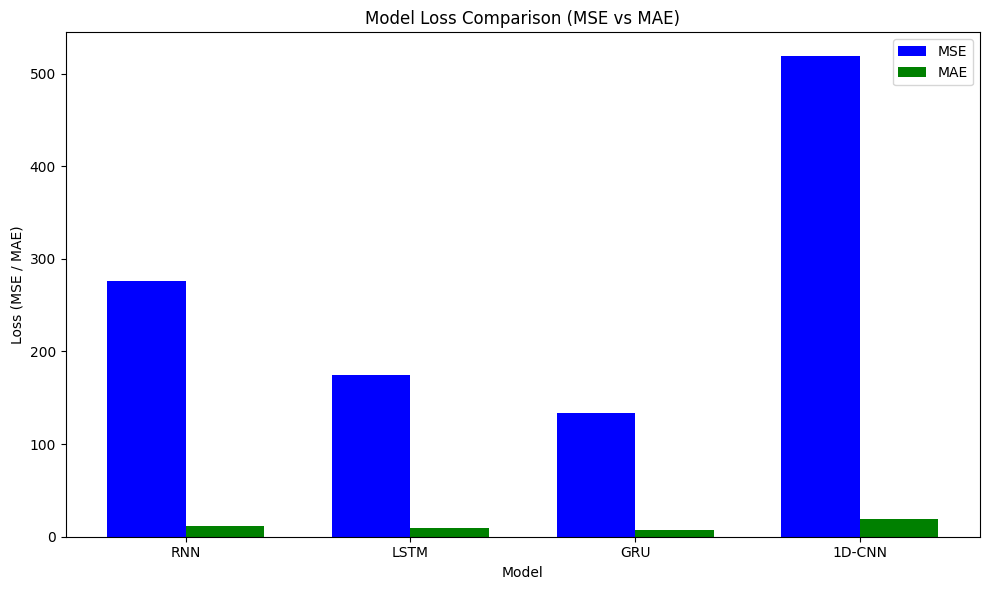

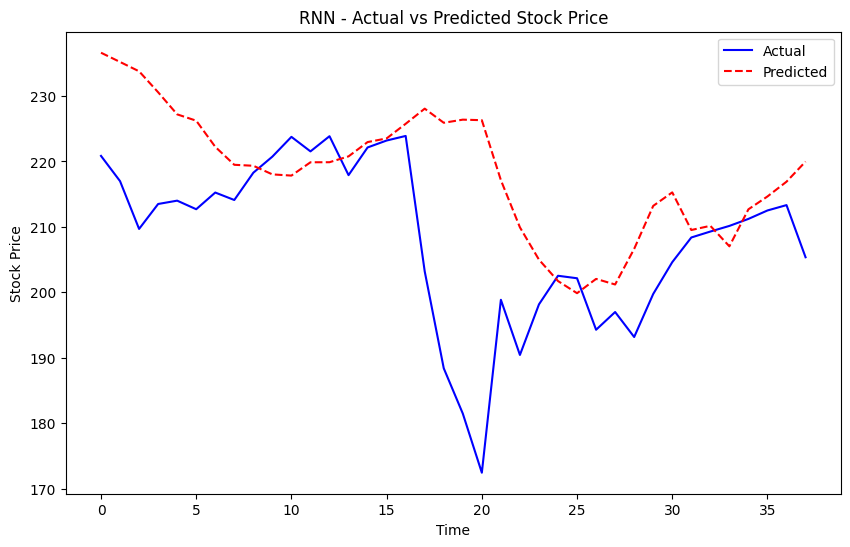

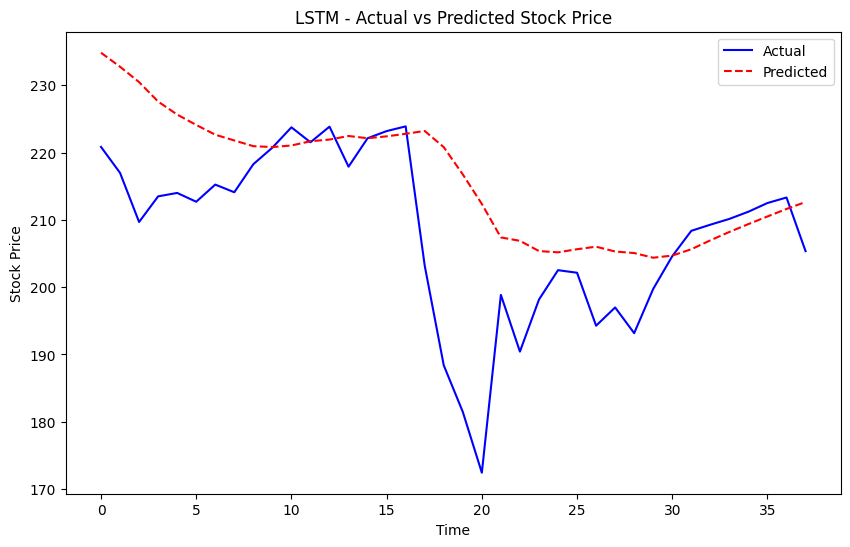

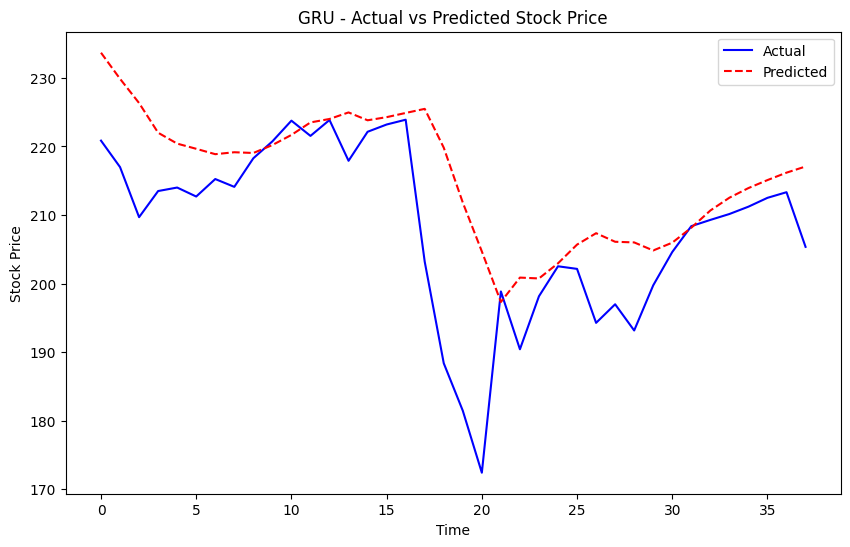

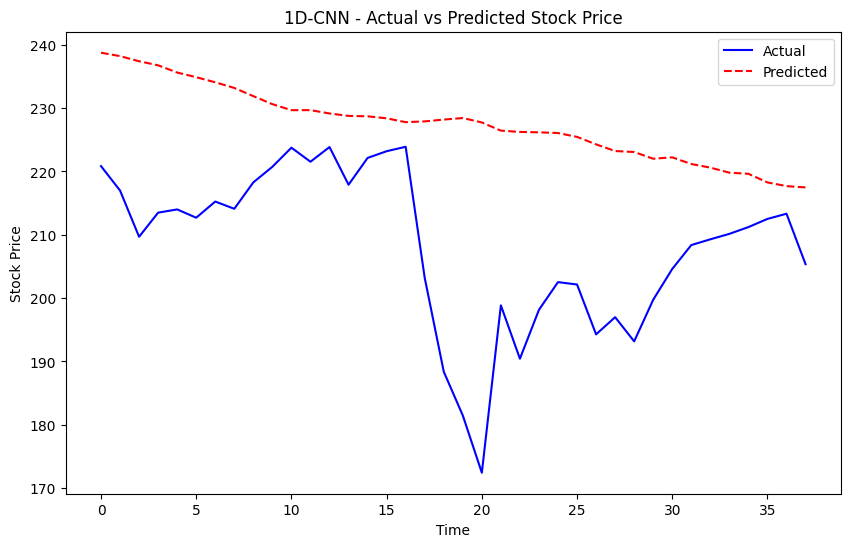

Best model based on MSE: GRU
Best model based on MAE: GRU

Future 7-day stock price predictions using the best model:
[217.06729 218.70259 220.20964 221.58426 222.83095 223.95781 224.97432]


In [23]:
# Main function
def main():
    ticker = input("Enter the stock ticker (e.g., AAPL, MSFT, TSLA): ")
    df = fetch_stock_data(ticker)

    results = {}
    for model_name in ["RNN", "LSTM", "GRU", "1D-CNN"]:
        results[model_name] = run_model_pipeline(model_name, df)

    plot_loss_comparison(results)

    for model_name in ["RNN", "LSTM", "GRU", "1D-CNN"]:
        plot_predictions(model_name, results[model_name]["actual"], results[model_name]["predictions"])

    best_model = min(results, key=lambda model: results[model]["MSE"])
    print(f"Best model based on MSE: {best_model}")

    best_model_mae = min(results, key=lambda model: results[model]["MAE"])
    print(f"Best model based on MAE: {best_model_mae}")

    print("\nFuture 7-day stock price predictions using the best model:")
    print(results[best_model]["Future 7 Days"])

# Run the main function
main()